In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/colabdataset/satelliteimg.zip

Archive:  /content/drive/MyDrive/colabdataset/satelliteimg.zip
   creating: satelliteimg/
   creating: satelliteimg/train/
  inflating: satelliteimg/train/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif  
  inflating: satelliteimg/train/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif  
  inflating: satelliteimg/train/global_monthly_2018_02_mosaic_L15-0331E-1257N_1327_3160_13.tif  
  inflating: satelliteimg/train/global_monthly_2018_03_mosaic_L15-0331E-1257N_1327_3160_13.tif  
  inflating: satelliteimg/train/global_monthly_2018_04_mosaic_L15-0357E-1223N_1429_3296_13.tif  
   creating: satelliteimg/trainannot/
  inflating: satelliteimg/trainannot/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.png  
 extracting: satelliteimg/trainannot/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.png  
  inflating: satelliteimg/trainannot/global_monthly_2018_02_mosaic_L15-0331E-1257N_1327_3160_13.png  
  inflating: satelliteimg/trainannot/global_mont

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import random

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize

from torch.nn import Sequential
from torch.nn import Conv2d, ReLU, Sigmoid, BatchNorm2d, Dropout

from torchvision.models.segmentation import fcn_resnet101

In [7]:
#Defining the directory path for train , validation images
x_train_dir = '/content/satelliteimg/train'
y_train_dir = '/content/satelliteimg/trainannot'

x_val_dir = '/content/satelliteimg/val'
y_val_dir = '/content/satelliteimg/valannot'

In [33]:
# define custom dataset class
class SatelliteDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i]).convert("RGB")
            mask = Image.open(self.masks_paths[i]).convert("L")
            # preprocess mask
            mask = np.array(mask)
            threshold_value = 127  # Adjust this threshold value as needed
            mask = (mask > threshold_value).astype(np.uint8)  # Pixels above threshold become 1, others become 0
            mask = Image.fromarray(mask * 255)  # Convert to 0-255 scale for PIL Image

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            return image, mask

        else:
            # read data
            image = Image.open(self.images_paths[i])

            # apply transforms
            image = self.transforms(image)

            return image

    def __len__(self):
        return len(self.image_names)


In [34]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = SatelliteDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    training_type='train'
)

# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=5,
    num_workers=4
)

In [35]:
image, gt_mask = train_dataset[0]
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

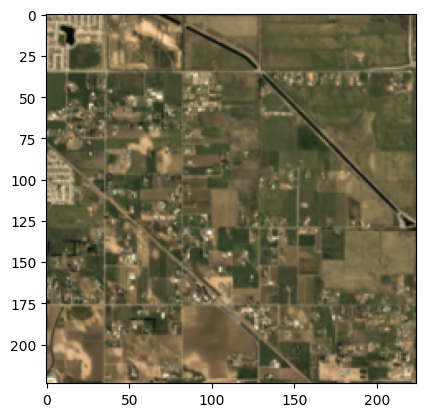

In [36]:
plt.imshow(np.transpose(image, (1, 2, 0)))

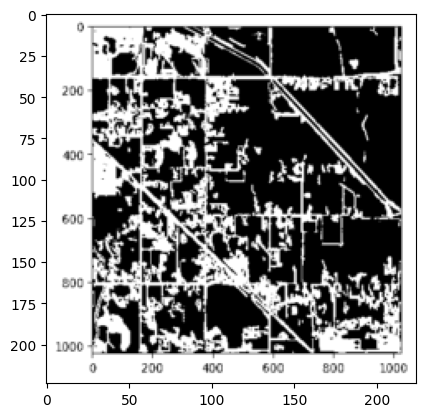

In [37]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [38]:
for batch_x, batch_y in train_loader:
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [39]:
batch_x.shape, batch_y.shape

(torch.Size([5, 3, 224, 224]), torch.Size([5, 1, 224, 224]))

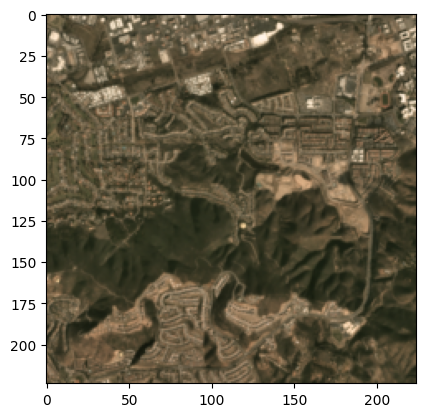

In [40]:
# Assuming batch_x is a batch of images
plt.imshow(batch_x[2].permute(1, 2, 0))
plt.show()

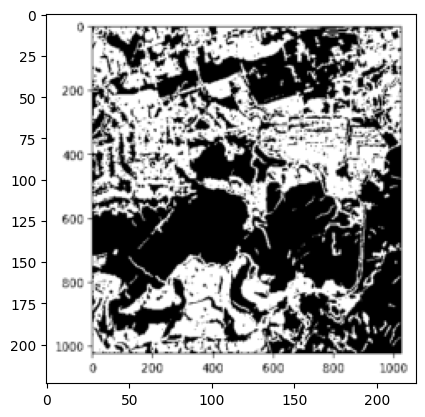

In [42]:
# Assuming batch_x is a batch of images
plt.imshow(batch_y[2].permute(1, 2, 0),cmap='gray')
plt.show()

In [43]:
# define model
model = fcn_resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 145MB/s]


In [44]:
# print model
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [45]:
# freeze model parameters
for parameters in model.parameters():
    parameters.requires_grad = False

In [46]:
model.classifier = Sequential(
    Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    ReLU(),
    Dropout(p=0.1, inplace=False),
    Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)),
    Sigmoid()
)

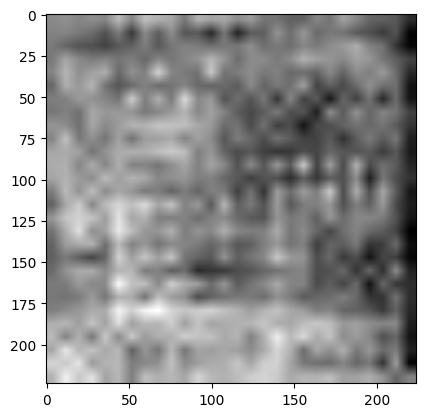

In [48]:
# check model on one image
model.eval()
output = model(batch_x[2].view(1, 3, 224, 224))['out'].detach().numpy()
# print output
plt.imshow(output.squeeze(),cmap='gray')

In [49]:
# transfer model to GPU
model = model.to("cuda")

In [50]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

In [51]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in train_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs['out'], batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.7002293467521667 
Training loss for epoch 2 is 0.9241829514503479 
Training loss for epoch 3 is 0.7078863978385925 
Training loss for epoch 4 is 0.6188585758209229 
Training loss for epoch 5 is 0.5820857882499695 


In [64]:
# get sample data
image1 = Image.open('/content/satelliteimg/train/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif').convert("RGB")
gt_mask1 = Image.open('/content/satelliteimg/trainannot/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.png').convert("L")

In [65]:
# preprocess mask
gt_mask = np.array(gt_mask1)
threshold_value = 127  # Adjust this threshold value as needed
gt_mask = (gt_mask > threshold_value).astype(np.uint8)  # Pixels above threshold become 1, others become 0
gt_mask = Image.fromarray(gt_mask * 255)  # Convert to 0-255 scale for PIL Image

# apply data augmentation
transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

image = transform(image1)
gt_mask = transform(gt_mask)


In [66]:
model.eval()
output1 = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

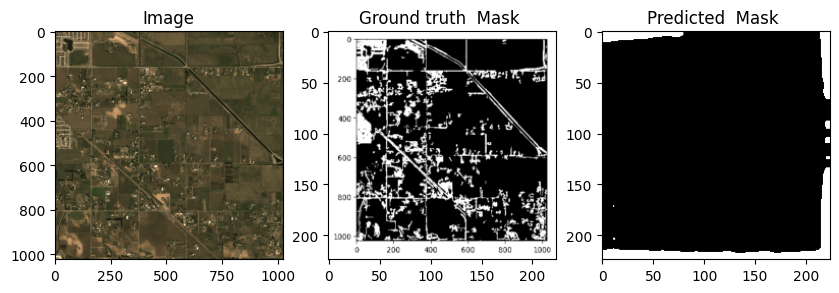

In [71]:
plt.figure(figsize=(10, 5))

# Display the Image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image')

# Display the image ground truth mask in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(gt_mask.squeeze(), cmap='gray')
plt.title('Ground truth  Mask ')

# Display the predicted mask in the second subplot
plt.subplot(1, 3, 3)
plt.imshow((output1.squeeze() >0.4).astype(int), cmap='gray')
plt.title('Predicted  Mask ')

plt.show()

In [72]:
# Calculating IOU score
# convert predicted mask to flattened numpy array
mask = (output1.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.22801917183939654

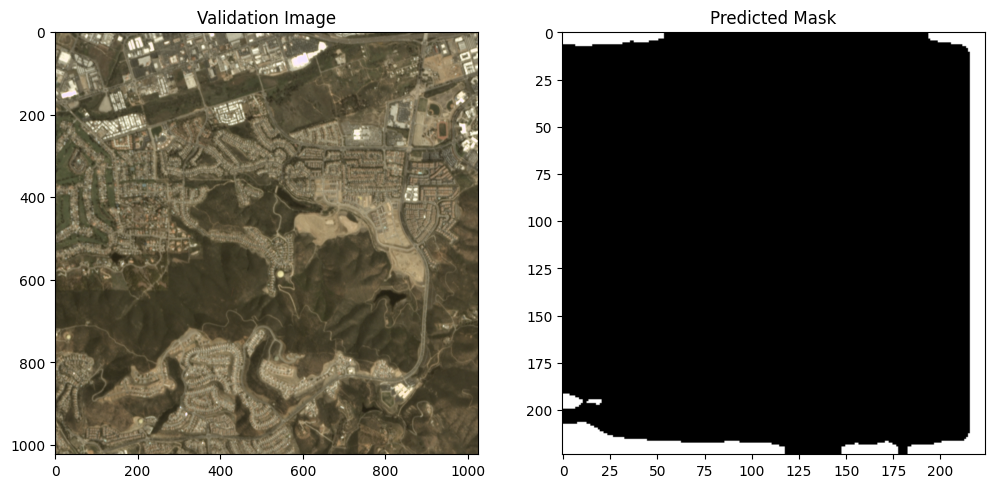

In [74]:
val_image =Image.open('/content/satelliteimg/train/global_monthly_2018_04_mosaic_L15-0357E-1223N_1429_3296_13.tif').convert('RGB')
# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

test_image = transform(val_image)
model.eval()
output_test = model(test_image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()
predicted_mask =(output_test.squeeze()>0.5).astype(int)

# Visualize the prediction
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(val_image)
plt.title('Validation Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()